In [1]:
import numpy as np
import sympy
import matplotlib.pylab as plt
%matplotlib inline

**Description of lag calculation from Siegel et al. 2015 (JCBFM)**

$$C_i(\tau) = (1/n_\tau)\sum \left[ \frac{g(t) \cdot s_i(t + \tau)}{\sigma_{s_i}\sigma_g}  \right]$$

* ***g*** is the gray matter signal
* ***s<sub>i</sub>*** is the signal in voxel ***i***
* ***σ<sub>s<sub>i</sub></sub>*** and  ***σ<sub>g</sub>*** are the standard deviations of the two signals

The summation runs over frames indexed by ***t***, and ***n<sub>τ</sub>***  is the number of frames included after a shift of ***τ***.

To determine the shift that maximizes the cross-correlation function at a temporal resolution finer than 1 TR, the lag (***τ***) corresponding to the maximum of ***C<sub>i</sub> (τ)*** is identified. ***C<sub>i</sub> (τ)*** at this lag, as well as one step forward and backward, is fit with a parabolic function and the peak value, ***C<sub>i</sub>  (τ<sup>m</sup>)*** and corresponding temporal shift ***(τ<sup>m</sup>)*** is computed. Positive and negative values of  ***τ<sup>m</sup>*** correspond, respectively, to a lag or lead relative to the mean gray matter signal.

In [2]:
def get_numerator(signal_a, signal_b, lag):
    if lag == 0:
        numerator = np.multiply(signal_a, signal_b)
    if lag > 0:
        numerator = np.multiply(signal_a[lag:], signal_b[0:-lag])
    if lag < 0:
        numerator = np.multiply(signal_b[-lag:], signal_a[0:lag])
    return numerator

In [3]:
def get_denominator(signal_a, signal_b):
    return np.std(signal_a) * np.std(signal_b)

In [4]:
def xcorr(signal_a, signal_b, lags):
    corr_vals = []
    for i in lags:
        corr = np.true_divide(1., len(signal_a)-i) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, i),
              get_denominator(signal_a, signal_b)))
        corr_vals.append(corr)
    return corr_vals

Now, let's generate some test data.

First, two aperiodic time-series, with a lag difference of 3 frames.

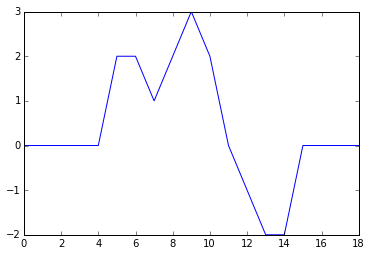

In [245]:
signal_a = [0, 0, 0, 0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0]
plt.plot(signal_a)

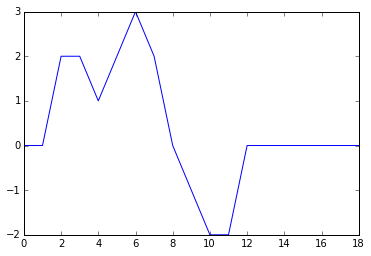

In [246]:
signal_b = [0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0, 0, 0, 0]
plt.plot(signal_b)

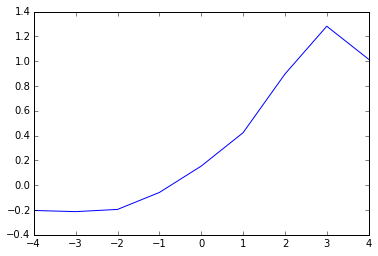

In [249]:
lags = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
plt.plot(lags, xcorr(signal_a, signal_b, lags))

In [5]:
from __future__ import division
from numpy import polyfit, arange

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)


In [159]:
import statsmodels as sm

In [177]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arima_process.arma_generate_sample(ar, ma, 250)

In [207]:
z = sm.tsa.arima_process.arma_generate_sample(ar, ma, 250)

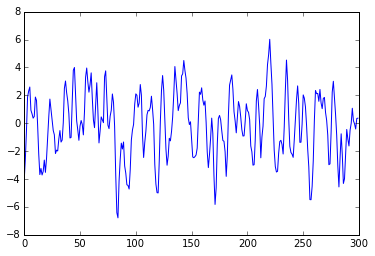

In [214]:
signal_a = np.append(z[-50:], y)
plt.plot(signal_a)

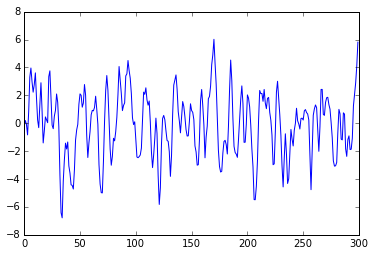

In [232]:
signal_b = np.append(y, z[0:50])
plt.plot(signal_b)

In [240]:
lags = [-64, -56, -48, -40, -32, -24, -16, -8, 0, 8, 16, 24, 32, 40, 48, 56, 64]

In [241]:
xcorr = []
for i in lags:
    corr = np.true_divide(1., len(signal_a)-i) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, i),
              get_denominator(signal_a, signal_b)))
    xcorr.append(corr)

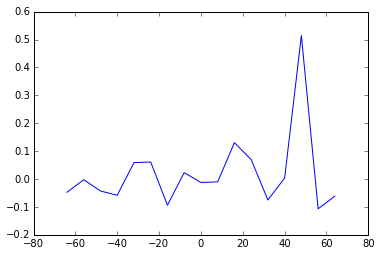

In [242]:
plt.plot(lags, xcorr)

In [243]:
print(np.max(xcorr), np.argmax(xcorr), lags[np.argmax(xcorr)])

(0.51414852754317775, 14, 48)


In [244]:
parabolic(xcorr, 14)

(13.951283646717062, 0.51549174023347044)

## Test on Real Data

In [6]:
epi = '/home/despoB/mb3152/data/nki_data/preprocessed/pipeline_pipeline/0197584_session_1/functional_mni/_scan_RfMRI_std_2500_rest/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf0/_bandpass_freqs_0.009.0.08/bandpassed_demeaned_filtered_antswarp.nii.gz'
brain_mask = '/home/despoB/mb3152/data/nki_data/preprocessed/pipeline_pipeline/0197584_session_1/functional_brain_mask_to_standard/_scan_RfMRI_std_2500_rest/rest_calc_tshift_resample_volreg_brain_mask_ero_antswarp.nii.gz'
gm_mask = '/home/despo/dlurie/Software/fsl/data/standard/tissuepriors/2mm/avg152T1_gray_bin.nii.gz'

In [7]:
import nibabel as nib

In [8]:
epi_img = nib.load(epi).get_data()

In [9]:
brain_mask_img = nib.load(brain_mask).get_data()
brain_mask_img = brain_mask_img.astype(bool)

In [10]:
gm_mask_img = nib.load(gm_mask).get_data()
gm_mask_img = gm_mask_img.astype(bool)

In [11]:
epi_gm_masked = epi_img[gm_mask_img]
epi_gm_masked.shape

(128190, 120)

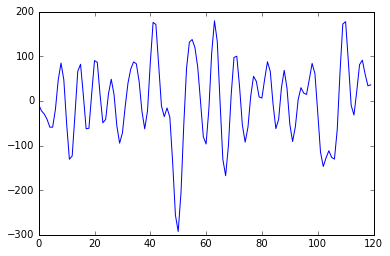

In [19]:
plt.plot(epi_gm_masked[-1])

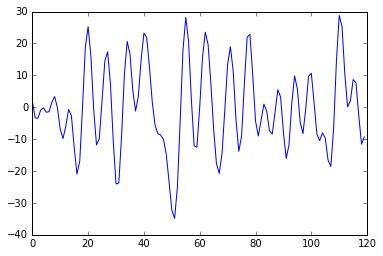

In [18]:
plt.plot(np.mean(epi_gm_masked, axis=0))

In [15]:
short_lags = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

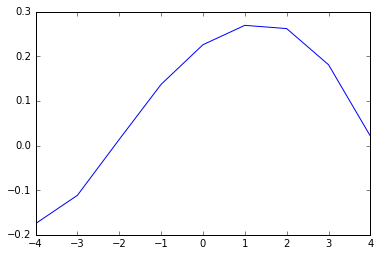

In [25]:
frame_slider = IntSlider(min=100, max=200, step1=1, value=0)
# decorate the plot function with an environment from the UIs:
@interact(frame_select=frame_slider)
def xcorr_viewer(frame_select):
    test_xcorr = xcorr(epi_gm_masked[frame_select], np.mean(epi_gm_masked, axis=0), short_lags)
    plt.plot(short_lags, test_xcorr)

In [26]:
test_xcorr = xcorr(epi_gm_masked[178], np.mean(epi_gm_masked, axis=0), short_lags)

In [21]:
from scipy import signal

In [27]:
np.argmax(test_xcorr)

0

In [28]:
signal.argrelmax(np.array(test_xcorr), order=1)

(array([4]),)

In [23]:
parabolic(test_xcorr, 5)[0] - 4

0.9421620933549022

In [231]:
lags = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [212]:
def gen_lag_map(epi_img, brain_mask_img, gm_mask_img, lags):
    epi_gm_masked = epi_img[gm_mask_img]
    signal_a = np.mean(epi_gm_masked, axis=0)
    epi_brain_masked = epi_img[brain_mask_img]
    lag_index_correction = np.sum(np.array(lags) > 0)
    xcorr_array = []
    for voxel in epi_brain_masked:
    #for i, voxel in enumerate(epi_brain_masked):
        #print(i)
        signal_b = voxel
        vox_xcorr = xcorr(signal_a, signal_b, lags)
        xcorr_max = np.argmax(vox_xcorr)
        if xcorr_max == 0:
            interp_max = xcorr_max
        elif xcorr_max == len(vox_xcorr)-1:
            interp_max = xcorr_max
        else:
            interp_max = parabolic(vox_xcorr, xcorr_max)[0]
            interp_max = interp_max - lag_index_correction
        xcorr_array.append(interp_max)
    return(np.array(xcorr_array))

In [213]:
test_out = gen_lag_map(epi_img, brain_mask_img, gm_mask_img, lags)

In [215]:
unmasked_data = np.zeros(brain_mask_img.shape, dtype=test_out.dtype)
unmasked_data[brain_mask_img] = test_out

In [219]:
a = np.ma.masked_where(unmasked_data == 0, unmasked_data)

In [13]:
from ipywidgets import interact, IntSlider

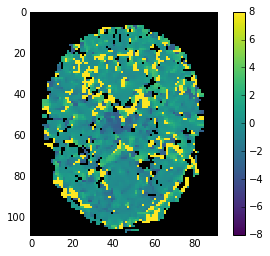

In [240]:
slice_slider = IntSlider(min=0, max=91, step1=1, value=45)
# decorate the plot function with an environment from the UIs:
@interact(slice_select=slice_slider)
def slice_viewer(slice_select):
    plt.imshow(a.T[slice_select,:,:], cmap='viridis', vmin=-8, vmax=8, interpolation='Nearest')
    plt.colorbar()